# Getting started with Word2Vec in Gensim and making it work!

The idea behind Word2Vec is pretty simple. We are making and assumption that you can tell the meaning of a word by the company it keeps. This is analogous to the saying *show me your friends, and I'll tell who you are*. So if you have two words that have very similar neighbors (i.e. the usage context is about the same), then these words are probably quite similar in meaning or are at least highly related. For example, the words `shocked`,`appalled` and `astonished` are typically used in a similar context. 

In this tutorial, you will learn how to use the Gensim implementation of Word2Vec and actually get it to work! I have heard a lot of complaints about poor performance etc, but its really a combination of two things, (1) your input data and (2) your parameter settings. Note that the training algorithms in this package were ported from the [original Word2Vec implementation by Google](https://arxiv.org/pdf/1301.3781.pdf) and extended with additional functionality.

### Imports and logging

First, we start with our imports and get logging established:

In [1]:
# imports needed and set up logging
import gzip 
import logging

# 'pip install gensim'
import gensim # word2vec

from sklearn.decomposition import PCA

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


C:\Users\Hasan\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Dataset 
Next, is our dataset. The secret to getting Word2Vec really working for you is to have lots and lots of text data. In this case I am going to use data from the [OpinRank](http://kavita-ganesan.com/entity-ranking-data/) dataset. This dataset has full user reviews of cars and hotels. I have specifically concatenated all of the hotel reviews into one big file which is about 97MB compressed and 229MB uncompressed. We will use the compressed file for this tutorial. Each line in this file represents a hotel review. You can download the OpinRank Word2Vec dataset here.

To avoid confusion, while gensim’s word2vec tutorial says that you need to pass it a sequence of sentences as its input, you can always pass it a whole review as a sentence (i.e. a much larger size of text), and it should not make much of a difference. 

Now, let's take a closer look at this data below by printing the first line. You can see that this is a pretty hefty review.

In [ ]:
data_file="reviews_data.txt.gz"

with gzip.open ('reviews_data.txt.gz', 'rb') as f:
    for i,line in enumerate (f):
        print(line)
        break


### Read files into a list
Now that we've had a sneak peak of our dataset, we can read it into a list so that we can pass this on to the Word2Vec model. Notice in the code below, that I am directly reading the 
compressed file. I'm also doing a mild pre-processing of the reviews using `gensim.utils.simple_preprocess (line)`. This does some basic pre-processing such as tokenization, lowercasing, etc and returns back a list of tokens (words). Documentation of this pre-processing method can be found on the official [Gensim documentation site](https://radimrehurek.com/gensim/utils.html). 



In [ ]:

def read_input(input_file):
    """This method reads the input file which is in gzip format"""
    
    logging.info("reading file {0}...this may take a while".format(input_file))
    
    with gzip.open (input_file, 'rb') as f:
        for i, line in enumerate (f): 

            if (i%10000==0):
                logging.info ("read {0} reviews".format (i))
            # do some pre-processing and return a list of words for each review text
            yield gensim.utils.simple_preprocess (line)

# read the tokenized reviews into a list
# each review item becomes a serries of words
# so this becomes a list of lists
documents = list (read_input (data_file))
logging.info ("Done reading data file")    

## Training the Word2Vec model

Training the model is fairly straightforward. You just instantiate Word2Vec and pass the reviews that we read in the previous step (the `documents`). So, we are essentially passing on a list of lists. Where each list within the main list contains a set of tokens from a user review. Word2Vec uses all these tokens to internally create a vocabulary. And by vocabulary, I mean a set of unique words.

After building the vocabulary, we just need to call `train(...)` to start training the Word2Vec model. Training on the [OpinRank](http://kavita-ganesan.com/entity-ranking-data/) dataset takes about 10 minutes so please be patient while running your code on this dataset.

Behind the scenes we are actually training a simple neural network with a single hidden layer. But, we are actually not going to use the neural network after training. Instead, the goal is to learn the weights of the hidden layer. These weights are essentially the word vectors that we’re trying to learn. 

In [ ]:
model = gensim.models.Word2Vec (documents, size=150, window=10, min_count=2, workers=10)
model.train(documents,total_examples=len(documents),epochs=10)

## Lets save our model
This way we can reuse it, instead of re-training it everytime.

In [ ]:
model.save('saved_model.bin')

In [2]:
# Load from disk
model = gensim.models.word2vec.Word2Vec.load('saved_model.bin')

2018-05-05 11:57:00,001 : INFO : loading Word2Vec object from saved_model.bin
2018-05-05 11:57:00,197 : INFO : loading wv recursively from saved_model.bin.wv.* with mmap=None
2018-05-05 11:57:00,198 : INFO : loading vectors from saved_model.bin.wv.vectors.npy with mmap=None
2018-05-05 11:57:00,225 : INFO : setting ignored attribute vectors_norm to None
2018-05-05 11:57:00,228 : INFO : loading vocabulary recursively from saved_model.bin.vocabulary.* with mmap=None
2018-05-05 11:57:00,229 : INFO : loading trainables recursively from saved_model.bin.trainables.* with mmap=None
2018-05-05 11:57:00,231 : INFO : loading syn1neg from saved_model.bin.trainables.syn1neg.npy with mmap=None
2018-05-05 11:57:00,266 : INFO : setting ignored attribute cum_table to None
2018-05-05 11:57:00,267 : INFO : loaded saved_model.bin


https://radimrehurek.com/gensim/models/word2vec.html

The word vectors can also be instantiated from an existing file on disk in the word2vec C format as a KeyedVectors instance.

NOTE: It is impossible to continue training the vectors loaded from the C format because hidden weights, vocabulary frequency and the binary tree is missing:

In [ ]:
# By default, the model is saved in a binary format to save space.
# But they can also be stored as text-files in ASCII
#model.wv.save_word2vec_format('model.bin')

# If you’re finished training a model (i.e. no more updates, only querying), 
# then switch to the gensim.models.KeyedVectors instance in wv
#wv = word_vectors = model.wv
#del model

# Lade model von disk
# <class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>
#wv = gensim.models.KeyedVectors.load_word2vec_format('model.bin', binary=True)

## Google News word2vec model

Man kann auch das von Google trainierte model verwenden. Ist jedoch 1.53 GB gross!

In [ ]:
#from gensim.models import KeyedVectors
#filename = 'GoogleNews-vectors-negative300.bin'
#wv = KeyedVectors.load_word2vec_format(filename, binary=True)

## Now, let's look at some output 
This first example shows a simple case of looking up words similar to the word `dirty`. All we need to do here is to call the `most_similar` function and provide the word `dirty` as the positive example. This returns the top 10 similar words. 

In [3]:
w1 = "dirty"
model.wv.most_similar (positive=w1)

2018-05-05 11:55:24,914 : INFO : precomputing L2-norms of word weight vectors


[('filthy', 0.8658034801483154),
 ('unclean', 0.7791900038719177),
 ('stained', 0.7777577042579651),
 ('smelly', 0.7614975571632385),
 ('dusty', 0.7543730139732361),
 ('grubby', 0.7455094456672668),
 ('gross', 0.7319042682647705),
 ('dingy', 0.7283893823623657),
 ('soiled', 0.7206752896308899),
 ('mouldy', 0.720005214214325)]

That looks pretty good, right? Let's look at a few more. Let's look at similarity for `polite`, `france` and `shocked`. 

In [5]:
# look up top 6 words similar to 'polite'
w1 = ["polite"]
model.wv.most_similar (positive=w1,topn=6)

[('courteous', 0.917322039604187),
 ('friendly', 0.83488929271698),
 ('cordial', 0.8145367503166199),
 ('professional', 0.7882053852081299),
 ('curteous', 0.7776986956596375),
 ('attentive', 0.7610419392585754)]

In [6]:
# look up top 6 words similar to 'france'
w1 = ["france"]
model.wv.most_similar (positive=w1,topn=6)

[('germany', 0.6676010489463806),
 ('spain', 0.6297860741615295),
 ('canada', 0.6234460473060608),
 ('rome', 0.6024988293647766),
 ('barcelona', 0.5826010704040527),
 ('england', 0.580375075340271)]

In [7]:
# look up top 6 words similar to 'shocked'
w1 = ["shocked"]
model.wv.most_similar (positive=w1,topn=6)

[('amazed', 0.8077754974365234),
 ('horrified', 0.803573489189148),
 ('astonished', 0.7723854184150696),
 ('appalled', 0.7617233991622925),
 ('dismayed', 0.7589415907859802),
 ('stunned', 0.7568888664245605)]

That's, nice. You can even specify several positive examples to get things that are related in the provided context and provide negative examples to say what should not be considered as related. In the example below we are asking for all items that *relate to bed* only:

In [8]:
# get everything related to stuff on the bed
w1 = ["bed",'sheet','pillow']
w2 = ['couch']
model.wv.most_similar (positive=w1,negative=w2,topn=10)


[('duvet', 0.7125101685523987),
 ('blanket', 0.7029637098312378),
 ('mattress', 0.7026457190513611),
 ('quilt', 0.6885063648223877),
 ('matress', 0.6834874749183655),
 ('sheets', 0.6486868858337402),
 ('foam', 0.6366962790489197),
 ('pillowcase', 0.6355973482131958),
 ('pillows', 0.6321684122085571),
 ('pillowcases', 0.6215291619300842)]

### Similarity between two words in the vocabulary

You can even use the Word2Vec model to return the similarity between two words that are present in the vocabulary. 

In [9]:
# similarity between two different words
model.wv.similarity(w1="dirty",w2="smelly")

0.7614974488369618

In [10]:
# similarity between two identical words
model.wv.similarity(w1="dirty",w2="dirty")

0.9999999999999999

In [11]:
# similarity between two unrelated words
model.wv.similarity(w1="dirty",w2="clean")

0.27989921450444444

Under the hood, the above three snippets computes the cosine similarity between the two specified words using word vectors of each. From the scores, it makes sense that `dirty` is highly similar to `smelly` but `dirty` is dissimilar to `clean`. If you do a similarity between two identical words, the score will be 1.0 as the range of the cosine similarity score will always be between [0.0-1.0]. You can read more about cosine similarity scoring [here](https://en.wikipedia.org/wiki/Cosine_similarity).

### Find the odd one out
You can even use Word2Vec to find odd items given a list of items.

In [12]:
# Which one is the odd one out in this list?
model.wv.doesnt_match(["cat","dog","france"])

'france'

In [13]:
# Which one is the odd one out in this list?
model.wv.doesnt_match(["bed","pillow","duvet","shower"])


'shower'

## Visualizing

In [3]:
# retrieve all of the vectors from a trained model
X = model[model.wv.vocab]

C:\Users\Hasan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [4]:
# create a 2-dimensional PCA model of the word vectors
# because we can't visualize a matrix with so many dimensions
pca = PCA(n_components=2)
result = pca.fit_transform(X)

In [5]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, result[model.wv.vocab[word].index])
            for word in model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [6]:
points.head(10)

,word,x,y
0,oct,2.178449,-1.998453
1,nice,1.668718,9.084165
2,trendy,4.060791,1.476571
3,hotel,-3.744639,-4.740197
4,location,4.552614,-8.066911
5,not,-0.003996,2.151690
6,too,-4.118382,-2.510259
7,bad,-1.317045,5.572789
8,stayed,0.624605,5.969232
9,in,17.751509,3.577708


In [7]:
sns.set_context("poster")

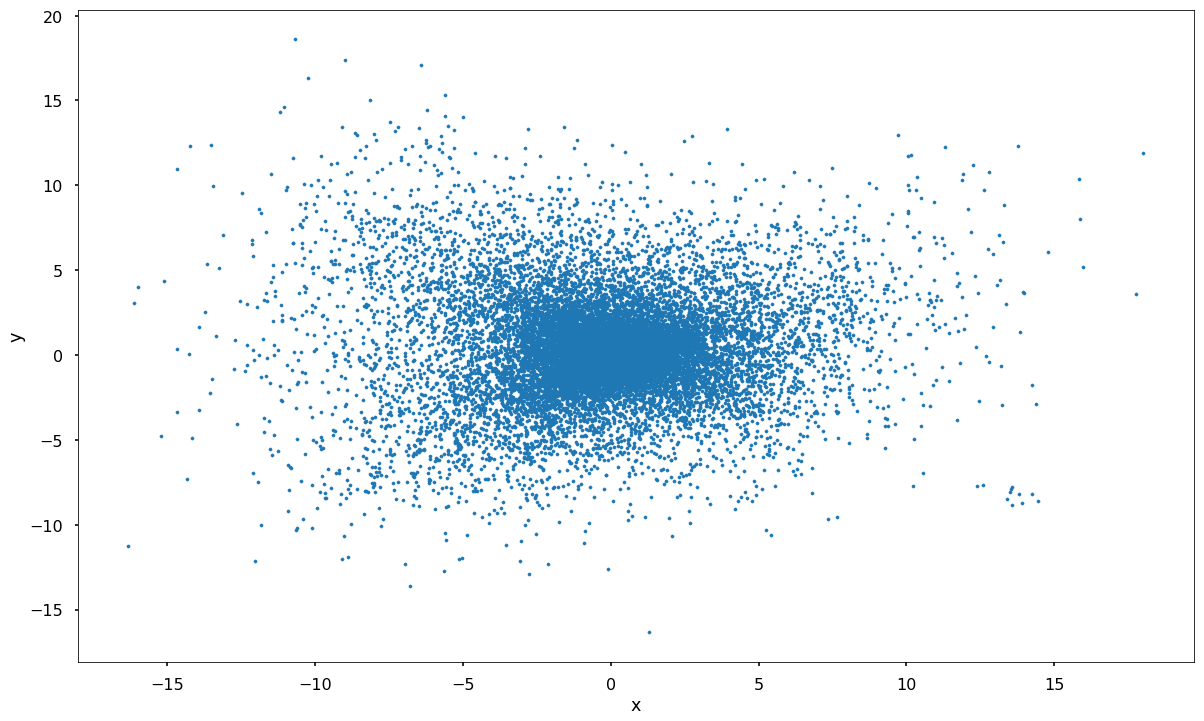

In [8]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [9]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
        
def plot_around_word(word, offset = 1):
    s = points[(points['word'] == word)]
    print(s)
    x = float(s['x'])
    y = float(s['y'])
    
    x_bounds = (x - (offset / 2), x + (offset / 2))
    y_bounds = (y - (offset / 2), y + (offset / 2))
    
    print('x_bounds', x_bounds)
    print('x_bounds', y_bounds)
    
    plot_region(x_bounds, y_bounds)

In [12]:
#plot_around_word('dirty', 1)

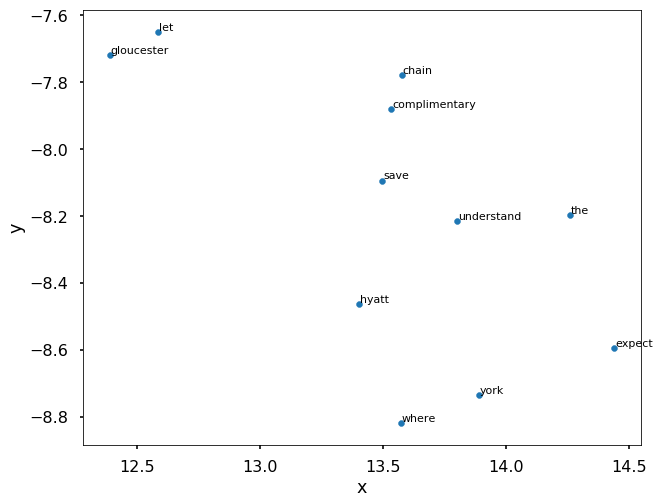

In [10]:
plot_region(x_bounds=(12.0, 15), y_bounds=(-11, -7))

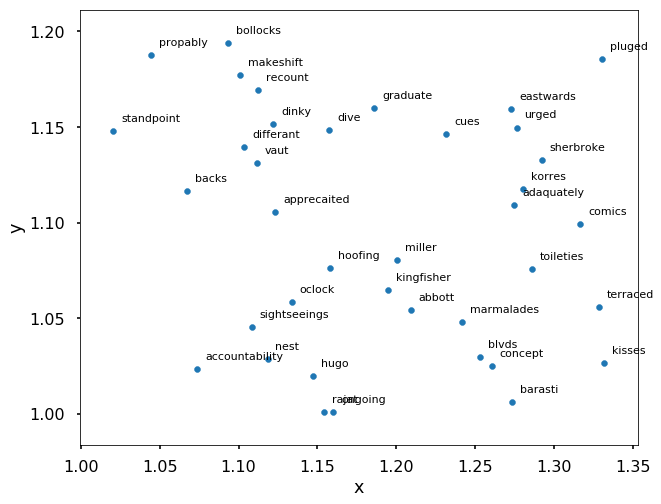

In [11]:
plot_region(x_bounds=(1, 1.4), y_bounds=(1, 1.2))

## Understanding some of the parameters
To train the model earlier, we had to set some parameters. Now, let's try to understand what some of them mean. For reference, this is the command that we used to train the model.

```
model = gensim.models.Word2Vec (documents, size=150, window=10, min_count=2, workers=10)
```

### `size`
The size of the dense vector to represent each token or word. If you have very limited data, then size should be a much smaller value. If you have lots of data, its good to experiment with various sizes. A value of 100-150 has worked well for me. 

### `window`
The maximum distance between the target word and its neighboring word. If your neighbor's position is greater than the maximum window width to the left and the right, then, some neighbors are not considered as being related to the target word. In theory, a smaller window should give you terms that are more related. If you have lots of data, then the window size should not matter too much, as long as its a decent sized window. 

### `min_count`
Minimium frequency count of words. The model would ignore words that do not statisfy the `min_count`. Extremely infrequent words are usually unimportant, so its best to get rid of those. Unless your dataset is really tiny, this does not really affect the model.

### `workers`
How many threads to use behind the scenes?


## When should you use Word2Vec?

There are many application scenarios for Word2Vec. Imagine if you need to build a sentiment lexicon. Training a Word2Vec model on large amounts of user reviews helps you achieve that. You have a lexicon for not just sentiment, but for most words in the vocabulary. 

Beyond, raw unstructured text data, you could also use Word2Vec for more structured data. For example, if you had tags for a million stackoverflow questions and answers, you could find tags that are related to a given tag and recommend the related ones for exploration. You can do this by treating each set of co-occuring tags as a "sentence" and train a Word2Vec model on this data. Granted, you still need a large number of examples to make it work. 
